Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
epoch: 25101/30000, d_loss: 0.65, d_acc: 0.52, g_loss: 1.04
1/1 [==============================] - 0s 26ms/step
epoch: 25201/30000, d_loss: 0.64, d_acc: 0.59, g_loss: 1.02
1/1 [==============================] - 0s 23ms/step
epoch: 25301/30000, d_loss: 0.61, d_acc: 0.62, g_loss: 1.04
1/1 [==============================] - 0s 27ms/step
epoch: 25401/30000, d_loss: 0.60, d_acc: 0.61, g_loss: 1.12
1/1 [==============================] - 0s 24ms/step
epoch: 25501/30000, d_loss: 0.61, d_acc: 0.61, g_loss: 0.94
1/1 [==============================] - 0s 24ms/step
epoch: 25601/30000, d_loss: 0.60, d_acc: 0.73, g_loss: 1.04
1/1 [==============================] - 0s 27ms/step
epoch: 25701/30000, d_loss: 0.60, d_acc: 0.64, g_loss: 1.03
1/1 [==============================] - 0s 27ms/step
epoch: 25801/30000, d_loss: 0.61, d_acc: 0.64, g_loss: 1.01
1/1 [==============================] - 0s 23ms/step
e

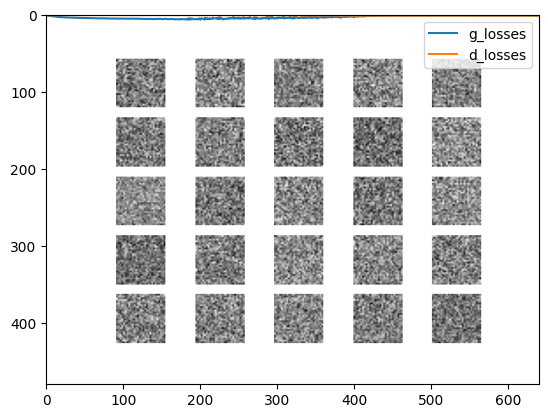

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load the MNIST Data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale the inputs in range of (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

print("x_train.shape:", x_train.shape)
print("x_test.shape:", x_test.shape)

# Dimensionality of the latent space
latent_dim = 100

# Defining the generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)
    model = Model(i, x)
    return model

# Defining the discriminator model
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    return model

# Compile both models in preparation for training
# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)
generator.summary()

discriminator.summary()

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))
z.shape

# Pass noise through generator to get an image
img = generator(z)
img

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
# Passing the output of Generator to the Discriminator
fake_pred = discriminator(img)

# Create the combined model object
combined_model_gen = Model(z, fake_pred)

# Compile the combined model
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Config
batch_size = 32
epochs = 30000
sample_period = 200  # every `sample_period` steps generate and save some data

# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

# A function to generate a grid of random samples from the generator and save them to a file
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)
    # Rescale images 0 - 1
    imgs = 0.5 * imgs + 0.5
    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

# Main training loop
for epoch in range(epochs):
    ###########################
    ### Train discriminator ###
    ###########################
    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    # Train the discriminator
    # both loss and accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    #######################
    ### Train generator ###
    #######################
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model_gen.train_on_batch(noise, ones)
    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
    if epoch % sample_period == 0:
        sample_images(epoch)

plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

# Display some generated images
from skimage.io import imread

a = imread('gan_images/0.png')
plt.imshow(a)
